# Image Captioning Final Project

In this final project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/encoder_decoder.png?raw=1" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# Import stuff

In [1]:
import sys
sys.path.append("..")
import grading
import download_utils

In [2]:
download_utils.link_all_keras_resources()

In [3]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os
from keras_utils import reset_tf_session
import tqdm_utils

Using TensorFlow backend.


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [4]:
grader = grading.Grader(assignment_key="NEDBg6CgEee8nQ6uE8a7OA", 
                        all_parts=["19Wpv", "uJh73", "yiJkt", "rbpnH", "E2OIL", "YJR7z"])

In [0]:
# token expires every 30 min
COURSERA_TOKEN = "pBllfBtw23JM2b77"
COURSERA_EMAIL = "mentarchik@gmail.com"

# Download data

Takes 10 hours and 20 GB. We've downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

In [5]:
# we downloaded them for you, just link them here
download_utils.link_week_6_resources()

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/inceptionv3.png?raw=1" style="width:70%">

In [6]:
IMG_SIZE = 299

In [43]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

So we've done it for you with the following code:
```python
# load pre-trained model
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [8]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [9]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['train2014_sample.zip', 'val2014_sample.zip']

# Extract captions for images

In [10]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


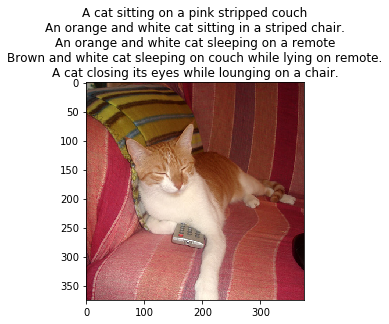

In [11]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

# Prepare captions for training

In [12]:
# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [13]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    
    #for captions in train_captions:
    #  for caption in captions:
    #    words = split_sentence(caption)
    
    words = [words for captions in train_captions for caption in captions for words in split_sentence(caption.lower())]
    
    words = np.reshape(words, -1)
    unique_words =np.unique(words)
    words_to_count = {w: 0 for w in unique_words}
    for w in words:
      words_to_count[w] = words_to_count[w] + 1
      
     
    
    vocab = [w for w, c in words_to_count.items() if c >= 5]
    vocab.append(PAD)
    vocab.append(UNK)
    vocab.append(START)
    vocab.append(END)
    
    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    
    vocabing_words = lambda words: [vocab[START]] + [vocab[w] if w in vocab else vocab[UNK] for w in words] + [vocab[END]]
    
    ing_words = lambda captions: [vocabing_words(split_sentence(caption.lower())) for caption in captions]
    res = [ing_words(caption_list) for caption_list in captions]
       
    return res

In [14]:
vocab = generate_vocabulary(train_captions)


In [15]:
# prepare vocabulary
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [16]:
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)

In [17]:
# replace tokens with indices

val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [18]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    
    max_len = max_len or max(map(len, batch_captions))
    max_len = min(max_len, max(map(len, batch_captions)))
    matrix = np.empty((len(batch_captions), max_len))
    matrix.fill(pad_idx)
    for i in range(len(batch_captions)):
        line_ix = list(batch_captions[i])[:max_len]
        matrix[i,:len(line_ix)] = line_ix

    
    return matrix

In [0]:
## GRADED PART, DO NOT CHANGE!
# Vocabulary creation
grader.set_answer("19Wpv", grading_utils.test_vocab(vocab, PAD, UNK, START, END))
# Captions indexing
grader.set_answer("uJh73", grading_utils.test_captions_indexing(train_captions_indexed, vocab, UNK))
# Captions batching
grader.set_answer("yiJkt", grading_utils.test_captions_batching(batch_captions_to_matrix))

In [0]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [19]:
# make sure you use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/encoder_decoder_explained.png?raw=1" style="width:50%">

In [20]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [21]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
#tf.reset_default_graph()
tf.set_random_seed(42)

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

Here's a figure to help you with flattening in decoder:
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/flatten_help.jpg?raw=1" style="width:80%">

In [22]:
#with tf.variable_scope(tf.get_variable_scope(), reuse=True):
  class decoder:
      # [batch_size, IMG_EMBED_SIZE] of CNN image features
      img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
      # [batch_size, time steps] of word ids
      sentences = tf.placeholder('int32', [None, None])

      # we use bottleneck here to reduce the number of parameters
      # image embedding -> bottleneck
      img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                        input_shape=(None, IMG_EMBED_SIZE), 
                                        activation='elu')
      # image embedding bottleneck -> lstm initial state
      img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                           input_shape=(None, IMG_EMBED_BOTTLENECK),
                                           activation='elu')
      # word -> embedding
      word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
      # lstm cell (from tensorflow)
      lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)

      # we use bottleneck here to reduce model complexity
      # lstm output -> logits bottleneck
      token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                        input_shape=(None, LSTM_UNITS),
                                        activation="elu")
      # logits bottleneck -> logits for next token prediction
      token_logits = L.Dense(len(vocab),
                             input_shape=(None, LOGIT_BOTTLENECK))

      # initial lstm cell state of shape (None, LSTM_UNITS),
      # we need to condition it on `img_embeds` placeholder.
      #c0 = h0 = img_embed_bottleneck_to_h0(img_embeds)
      c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))
      ### YOUR CODE HERE ###

      # embed all tokens but the last for lstm input,
      # remember that L.Embedding is callable,
      # use `sentences` placeholder as input.
      word_embeds = word_embed(sentences[:, :-1])
      ### YOUR CODE HERE ###

      # during training we use ground truth tokens `word_embeds` as context for next token prediction.
      # that means that we know all the inputs for our lstm and can get 
      # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
      # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
      hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                           initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

      # now we need to calculate token logits for all the hidden states

      # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
      flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])
      ### YOUR CODE HERE ###

      # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
      flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
      ### YOUR CODE HERE ###

      # then, we flatten the ground truth token ids.
      # remember, that we predict next tokens for each time step,
      # use `sentences` placeholder.
      #flat_ground_truth = tf.reshape(sentences, [tf.shape(flat_token_logits)[0]])
      flat_ground_truth = tf.reshape(sentences[:, 1:], [-1])
      #flat_hidden_states @ flat_token_logits
      ### YOUR CODE HERE ###

      # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
      # we don't want to propagate the loss for padded output tokens,
      # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.

        flat_loss_mask = tf.where (tf.equal( flat_ground_truth, tf.constant( pad_idx ) ) , tf.zeros_like(flat_ground_truth), tf.ones_like(flat_ground_truth)) 
      ### YOUR CODE HERE ###

      # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
      xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=flat_ground_truth, 
          logits=flat_token_logits
      )

      # compute average `xent` over tokens with nonzero `flat_loss_mask`.
      # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
      # we have PAD tokens for batching purposes only!
      loss = tf.reduce_mean( tf.where(tf.equal( flat_loss_mask, tf.constant( 1 ) ), xent, tf.zeros_like(xent) ) )
      #loss = tf.reduce_mean( tf.boolean_mask(xent, flat_loss_mask) )
      ### YOUR CODE HERE ###

In [23]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

In [0]:
## GRADED PART, DO NOT CHANGE!
# Decoder shapes test
grader.set_answer("rbpnH", grading_utils.test_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s))
# Decoder random loss test
grader.set_answer("E2OIL", grading_utils.test_random_decoder_loss(decoder, IMG_EMBED_SIZE, vocab, s))

In [0]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [24]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [25]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    #indxs = range(len(images_embeddings))
    #np.random.shuffle(indxs)
    
    #indxs = np.random.uniform(0, len(images_embeddings), batch_size).astype(np.int64)
    
    batch_start_idx =  np.random.randint(0, high=len(images_embeddings)-batch_size)
    idxs = np.random.permutation(range(len(images_embeddings)))[batch_start_idx : batch_start_idx+batch_size]
    
    #idxs = np.random.choice(range(len(images_embeddings)), batch_size)
    
    batch_image_embeddings = np.take(images_embeddings, idxs, axis=0)
    ### YOUR CODE HERE ###
    
    caption_inner_idxs = np.random.choice(range(5), batch_size)
    
    batch_captions_matrix = [indexed_captions[b][c] for b, c in zip(idxs, caption_inner_idxs)]
    batch_captions_matrix = batch_captions_to_matrix(batch_captions_matrix, pad_idx, max_len)
    ### YOUR CODE HERE ###
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [26]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [0]:
# you can load trained weights here
# you can load "weights_{epoch}" and continue training
# uncomment the next line if you need to load weights

# saver.restore(s, os.path.abspath("weights"))

Look at the training and validation loss, they should be decreasing!

In [63]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
     
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    #saver.save(s, os.path.abspath("weights_{}".format(epoch)))
    
print("Finished!")

**************************************************
Training loss: 2.661135


Uploading file weights-0.meta to folder Colab Notebooks:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, train loss: 2.661135327577591, val loss: 2.3063106513023377


Uploading file weights-0.meta to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 101.92it/s]
Uploading file weights-0.index to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 97.42it/s]
Uploading file weights-0.data-00000-of-00001 to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 65.37it/s]
Uploading file weights-0.checkpoint to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 63.42it/s]


**************************************************
Training loss: 2.085299


Uploading file weights-11.index to folder Colab Notebooks:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, train loss: 2.085298709988594, val loss: 1.9911271595954896


Uploading file weights-11.index to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 110.80it/s]
Uploading file weights-10.checkpoint to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 108.51it/s]
Uploading file weights-1.checkpoint to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 111.96it/s]
Uploading file weights-1.meta to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 121.05it/s]
Uploading file weights-1.data-00000-of-00001 to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 63.32it/s]
Uploading file weights-10.index to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 106.55it/s]
Uploading file weights-10.data-00000-of-00001 to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 54.64it/s]
Uploading file weights-10.meta to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 127.35it/s]
Uploading file weights-11.checkpoint to folder Colab Notebooks: 100%|██████████| 100/100 

**************************************************
Training loss: 1.884001


Uploading file weights-2.meta to folder Colab Notebooks:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2, train loss: 1.8840014758110046, val loss: 1.845221107006073


Uploading file weights-2.meta to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 94.30it/s]
Uploading file weights-2.checkpoint to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 117.64it/s]
Uploading file weights-2.index to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 116.82it/s]
Uploading file weights-2.data-00000-of-00001 to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 70.86it/s]


**************************************************
Training loss: 1.792270


Uploading file weights-3.data-00000-of-00001 to folder Colab Notebooks:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3, train loss: 1.7922696956396102, val loss: 1.8019169986248016


Uploading file weights-3.data-00000-of-00001 to folder Colab Notebooks: 100%|██████████| 100/100 [00:02<00:00, 49.15it/s]
Uploading file weights-3.checkpoint to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 113.85it/s]
Uploading file weights-3.meta to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 128.12it/s]
Uploading file weights-3.index to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 103.91it/s]


**************************************************
Training loss: 1.736258


Uploading file weights-4.index to folder Colab Notebooks:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4, train loss: 1.7362578666210176, val loss: 1.7491240835189819


Uploading file weights-4.index to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 111.68it/s]
Uploading file weights-4.checkpoint to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 109.18it/s]
Uploading file weights-4.meta to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 130.71it/s]
Uploading file weights-4.data-00000-of-00001 to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 61.75it/s]


**************************************************
Training loss: 1.690841


Uploading file weights-5.data-00000-of-00001 to folder Colab Notebooks:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5, train loss: 1.6908410068750381, val loss: 1.7471393060684204


Uploading file weights-5.data-00000-of-00001 to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 58.70it/s]
Uploading file weights-5.meta to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 122.52it/s]
Uploading file weights-5.index to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 102.10it/s]
Uploading file weights-5.checkpoint to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 108.69it/s]


**************************************************
Training loss: 1.668606


Uploading file weights-6.checkpoint to folder Colab Notebooks:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6, train loss: 1.6686059057712554, val loss: 1.6888056778907776


Uploading file weights-6.checkpoint to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 95.65it/s]
Uploading file weights-6.index to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 114.89it/s]
Uploading file weights-6.data-00000-of-00001 to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 59.86it/s]
Uploading file weights-6.meta to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 110.87it/s]


**************************************************
Training loss: 1.627324


Uploading file weights-7.meta to folder Colab Notebooks:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7, train loss: 1.627323616862297, val loss: 1.6855850315093994


Uploading file weights-7.meta to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 88.19it/s]
Uploading file weights-7.data-00000-of-00001 to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 67.20it/s]
Uploading file weights-7.checkpoint to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 89.12it/s]
Uploading file weights-7.index to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 100.82it/s]


**************************************************
Training loss: 1.608735


Uploading file weights-8.index to folder Colab Notebooks:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8, train loss: 1.608735228419304, val loss: 1.6516501009464264


Uploading file weights-8.index to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 114.29it/s]
Uploading file weights-8.checkpoint to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 100.16it/s]
Uploading file weights-8.data-00000-of-00001 to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 67.93it/s]
Uploading file weights-8.meta to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 115.22it/s]


**************************************************
Training loss: 1.592298


Uploading file weights-9.meta to folder Colab Notebooks:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9, train loss: 1.592297891497612, val loss: 1.649960834980011


Uploading file weights-9.meta to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 101.56it/s]
Uploading file weights-9.data-00000-of-00001 to folder Colab Notebooks: 100%|██████████| 100/100 [00:02<00:00, 37.19it/s]
Uploading file weights-9.index to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 105.36it/s]
Uploading file weights-9.checkpoint to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 95.88it/s]


**************************************************
Training loss: 1.570973


Uploading file weights-10.checkpoint to folder Colab Notebooks:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10, train loss: 1.5709726344347, val loss: 1.6546718883514404


Uploading file weights-10.checkpoint to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 89.67it/s]
Uploading file weights-10.index to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 93.03it/s]
Uploading file weights-10.data-00000-of-00001 to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 57.38it/s]
Uploading file weights-10.meta to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 113.10it/s]


**************************************************
Training loss: 1.563627


Uploading file weights-11.index to folder Colab Notebooks:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11, train loss: 1.5636267787218094, val loss: 1.621509200334549


Uploading file weights-11.index to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 109.48it/s]
Uploading file weights-11.checkpoint to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 108.35it/s]
Uploading file weights-11.meta to folder Colab Notebooks: 100%|██████████| 100/100 [00:00<00:00, 107.65it/s]
Uploading file weights-11.data-00000-of-00001 to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 66.71it/s]

Finished!


In [0]:
## GRADED PART, DO NOT CHANGE!
# Validation loss
grader.set_answer("YJR7z", grading_utils.test_validation_loss(
    decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

**************************************************



In [0]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [65]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))


def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
   
    
    logits = decoder.flat_token_logits.eval(fd)
    
    truth = decoder.flat_ground_truth.eval(fd)

    mask = decoder.flat_loss_mask.eval(fd).astype(bool)

    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 1.6293198
Accuracy: 0.453015427769986
Example 0
Predicted: a young sitting a a plate of a of a plate dish wine #END# #END# #END# and and
Truth: a kid drink from a glass in front of a food of plate #END# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a glass of a sitting a glass on a kitchen #END# #END# #END# #END# #END# #END# #END# and
Truth: some bottles of cleaner in a spot in the wall #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a up and on a open plate plate #END# a table plate #END# #END# #END# #END# and and
Truth: sliced bananas sit on an open faced sandwich on a paper plate #END# #PAD# #PAD# #PAD# #PAD# #PAD#



In [66]:
# save graph weights to file!
saver.save(s, os.path.abspath("weights"))

'/content/weights'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [38]:
import keras.backend as K
K.manual_variable_initialization(False)


In [28]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, os.path.abspath("weights"))  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from D:\Work\ProjectsWin8\!hseaml\intro-to-dl\intro-to-dl\week6\weights


In [29]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.999999999796 2.03703597592e-10 1.26765059997e-70 with temperature 0.01
0.903037043325 0.0969628642039 9.24709932365e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.353447726392 0.345648113606 0.300904160002 with temperature 10
0.335367280481 0.334619764349 0.33001295517 with temperature 100


In [54]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    K.set_learning_phase(False)
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {
              final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

InvalidArgumentError: You must feed a value for placeholder tensor 'batch_normalization/keras_learning_phase' with dtype bool
	 [[Node: batch_normalization/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=<unknown>, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'batch_normalization/keras_learning_phase', defined at:
  File "d:\Anaconda3\envs\hseaml\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "d:\Anaconda3\envs\hseaml\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\ipykernel\kernelapp.py", line 499, in start
    self.io_loop.start()
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "d:\Anaconda3\envs\hseaml\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "d:\Anaconda3\envs\hseaml\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "d:\Anaconda3\envs\hseaml\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\ipykernel\kernelbase.py", line 346, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\ipykernel\kernelbase.py", line 259, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\ipykernel\kernelbase.py", line 513, in execute_request
    user_expressions, allow_stdin,
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\IPython\core\interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\IPython\core\interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\IPython\core\interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\IPython\core\interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\IPython\core\interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-8f035fa95d6d>", line 1, in <module>
    class final_model:
  File "<ipython-input-28-8f035fa95d6d>", line 3, in final_model
    encoder, preprocess_for_model = get_cnn_encoder()
  File "<ipython-input-7-c728367ecc2d>", line 4, in get_cnn_encoder
    model = keras.applications.InceptionV3(include_top=False)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tensorflow\contrib\keras\python\keras\applications\inception_v3.py", line 183, in InceptionV3
    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tensorflow\contrib\keras\python\keras\applications\inception_v3.py", line 96, in conv2d_bn
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tensorflow\contrib\keras\python\keras\engine\topology.py", line 432, in __call__
    output = super(Layer, self).__call__(inputs, **kwargs)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tensorflow\python\layers\base.py", line 441, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tensorflow\contrib\keras\python\keras\layers\normalization.py", line 118, in call
    training = K.learning_phase()
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tensorflow\contrib\keras\python\keras\backend.py", line 320, in learning_phase
    phase = array_ops.placeholder(dtype='bool', name='keras_learning_phase')
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1530, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1954, in _placeholder
    name=name)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "d:\Anaconda3\envs\hseaml\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'batch_normalization/keras_learning_phase' with dtype bool
	 [[Node: batch_normalization/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=<unknown>, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


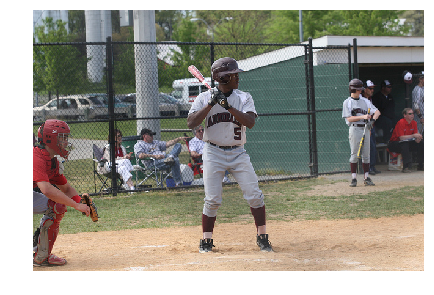

In [55]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

In [ ]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

You can download any image from the Internet and appply your model to it!

In [75]:
download_utils.download_file(
    "http://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg",
    "portal-cake-10.jpg"
)

**************************************************
portal-cake-10.jpg


a cake with a fork and a fork


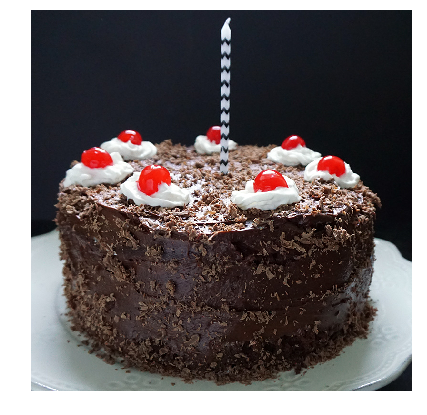

In [76]:
apply_model_to_image_raw_bytes(open("portal-cake-10.jpg", "rb").read())

Now it's time to find 10 examples where your model works good and 10 examples where it fails! 

You can use images from validation set as follows:
```python
show_valid_example(val_img_fns, example_idx=...)
```

You can use images from the Internet as follows:
```python
! wget ...
apply_model_to_image_raw_bytes(open("...", "rb").read())
```

If you use these functions, the output will be embedded into your notebook and will be visible during peer review!

When you're done, download your noteboook using "File" -> "Download as" -> "Notebook" and prepare that file for peer review!

In [79]:
! wget http://www.nokiaplanet.com/uploads/posts/2015-11/1448881894_cute-kitty-360x640.jpg
! wget http://www.radionetplus.ru/uploads/posts/2013-04/1365401196_teplye-oboi-1.jpeg
! wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTJIXmdd3wCWiepCZUEs99EwGbMgUB29BMHrBasL8e4Xiuaigs_rQ
! wget http://www.radionetplus.ru/uploads/posts/2013-07/1374306712_krasivye-oboi-1.jpg
! wget http://lifeglobe.net/x/entry/6130/1a-0.jpg
! wget https://millionstatusov.ru/pic/statpic/1764/51863_1.jpg
! wget https://bestcube.space/wp-content/uploads/0Jrvgf38V8.jpg
! wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQUgCXsrtihGQaPfnEioGe0iYW10FAWl0w5hNc52UcuIhTzT5pP
! wget https://kartinki.detki.today/wp-content/uploads/2017/07/kartinka-dlya-detey-lev-1150x863.jpg
! wget http://masyamba.ru/wp-content/uploads/2017/06/kartinki-pro-zmej.jpg
! wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRxFBxMZEomLew5lvahQzFed_BSa-UiPRzHqeHN_PqkddFrTF3d
! wget http://katyaburg.ru/sites/default/files/pictures/prikoly/krasivye_kartinki_o_lyubvi_foto_01.jpg
! wget https://millionstatusov.ru/pic/statpic/all/58e61c15039d3.jpg
! wget http://www.neumeka.ru/images/stat/int/skachat_kartinki/04.jpg
! wget https://mana.su/wp-content/uploads/2017/06/kartinka-simvol-2018-20.jpg
### YOUR EXAMPLES HERE ###

--2018-11-24 14:29:42--  http://www.nokiaplanet.com/uploads/posts/2015-11/1448881894_cute-kitty-360x640.jpg
Resolving www.nokiaplanet.com (www.nokiaplanet.com)... 95.216.94.230
Connecting to www.nokiaplanet.com (www.nokiaplanet.com)|95.216.94.230|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136605 (133K) [image/jpeg]
Saving to: ‘1448881894_cute-kitty-360x640.jpg.2’

1448881894_cute-kit 100%[===================>] 133.40K   214KB/s    in 0.6s    

2018-11-24 14:29:42 (214 KB/s) - ‘1448881894_cute-kitty-360x640.jpg.2’ saved [136605/136605]

--2018-11-24 14:29:43--  http://www.radionetplus.ru/uploads/posts/2013-04/1365401196_teplye-oboi-1.jpeg
Resolving www.radionetplus.ru (www.radionetplus.ru)... 109.120.162.1
Connecting to www.radionetplus.ru (www.radionetplus.ru)|109.120.162.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 753838 (736K) [image/jpeg]
Saving to: ‘1365401196_teplye-oboi-1.jpeg.1’

1365401196_teplye-o 100%[==============

In [92]:
! wget https://mana.su/wp-content/uploads/2017/06/kartinka-simvol-2018-20.jpg
! wget https://ianimal.ru/wp-content/uploads/2010/12/smeshnue-kartinki-zhivotnuh-8-01.jpg
! wget http://cdn1.imgbb.ru/user/72/727876/b4cdf8165df28033f9b9160f0b06ed68.jpg
! wget http://pristor.ru/wp-content/uploads/2017/05/%D0%9F%D1%80%D0%B8%D0%BA%D0%BE%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%B8-%D0%BA%D1%80%D0%B0%D1%81%D0%B8%D0%B2%D1%8B%D0%B5-%D0%BA%D0%B0%D1%80%D1%82%D0%B8%D0%BD%D0%BA%D0%B8-%D0%A1%D0%B0%D0%BD%D1%81%D0%B0-%D0%B8%D0%B7-%D0%90%D0%BD%D0%B4%D0%B5%D1%80%D1%82%D0%B5%D0%B9%D0%BB-4.jpg
! wget https://kartinki.detki.today/wp-content/uploads/2017/06/belka-kartinki-dlya-detey.jpg

--2018-11-24 14:46:47--  https://mana.su/wp-content/uploads/2017/06/kartinka-simvol-2018-20.jpg
Resolving mana.su (mana.su)... 78.24.223.122
Connecting to mana.su (mana.su)|78.24.223.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242305 (237K) [image/jpeg]
Saving to: ‘kartinka-simvol-2018-20.jpg.1’

kartinka-simvol-201 100%[===================>] 236.63K   553KB/s    in 0.4s    

2018-11-24 14:46:48 (553 KB/s) - ‘kartinka-simvol-2018-20.jpg.1’ saved [242305/242305]

--2018-11-24 14:46:49--  https://ianimal.ru/wp-content/uploads/2010/12/smeshnue-kartinki-zhivotnuh-8-01.jpg
Resolving ianimal.ru (ianimal.ru)... 87.236.16.60
Connecting to ianimal.ru (ianimal.ru)|87.236.16.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131465 (128K) [image/jpeg]
Saving to: ‘smeshnue-kartinki-zhivotnuh-8-01.jpg’

smeshnue-kartinki-z 100%[===================>] 128.38K   456KB/s    in 0.3s    

2018-11-24 14:46:50 (456 KB/s) - ‘smeshnue-kartinki-zhivo

a black and white cat standing next to a wooden table


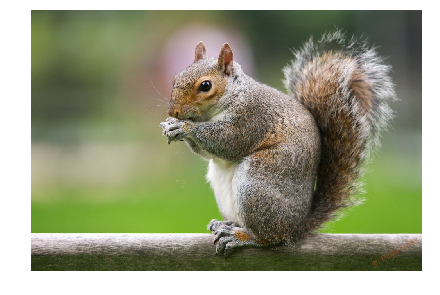

In [98]:
apply_model_to_image_raw_bytes(open("belka-kartinki-dlya-detey.jpg", "rb").read())

a cat is laying on a bed with a cat


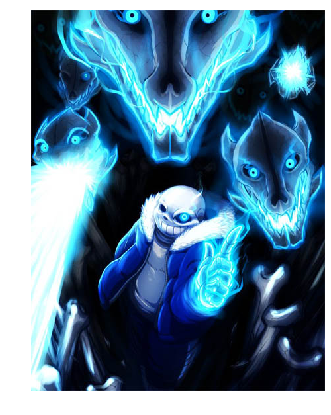

In [97]:
apply_model_to_image_raw_bytes(open("Прикольные-и-красивые-картинки-Санса-из-Андертейл-4.jpg", "rb").read())

a group of people standing on top of a beach


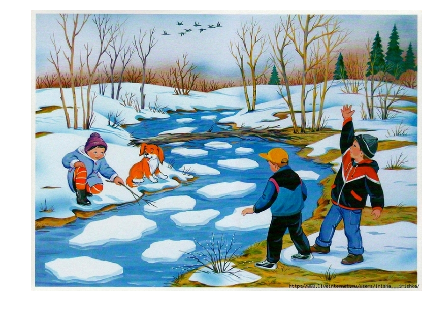

In [96]:
apply_model_to_image_raw_bytes(open("b4cdf8165df28033f9b9160f0b06ed68.jpg", "rb").read())

a polar bear is standing in the water


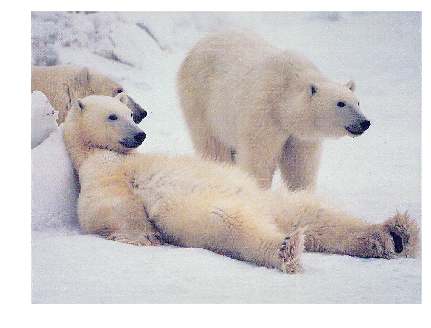

In [95]:
apply_model_to_image_raw_bytes(open("smeshnue-kartinki-zhivotnuh-8-01.jpg", "rb").read())

a cat is sitting on a table with a cat


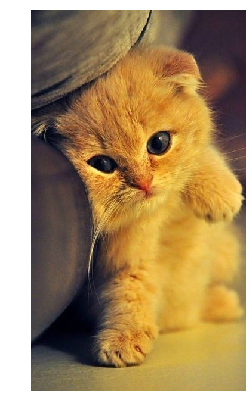

In [80]:
apply_model_to_image_raw_bytes(open("1448881894_cute-kitty-360x640.jpg", "rb").read())

a train is parked on a bridge near a body of water


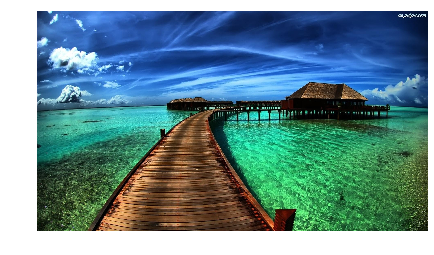

In [81]:
apply_model_to_image_raw_bytes(open("1365401196_teplye-oboi-1.jpeg", "rb").read())

a car parked on the side of a road


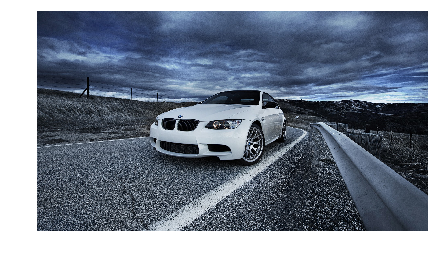

In [82]:
apply_model_to_image_raw_bytes(open("1374306712_krasivye-oboi-1.jpg", "rb").read())

a bird is standing in a tree next to a tree


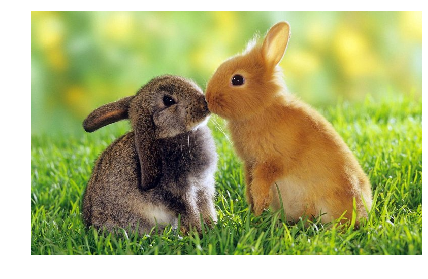

In [83]:
apply_model_to_image_raw_bytes(open("1a-0.jpg", "rb").read())

a man is standing on a surfboard in the water


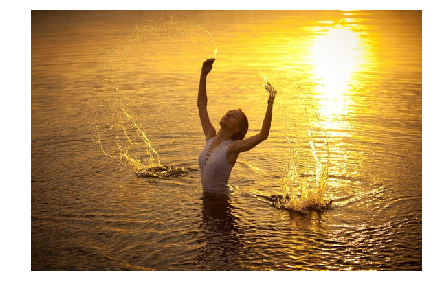

In [84]:
apply_model_to_image_raw_bytes(open("51863_1.jpg", "rb").read())

a large jetliner flying through the air over a field


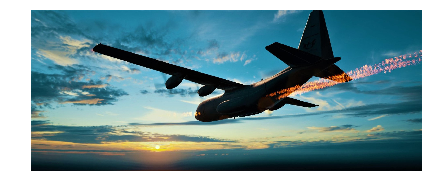

In [85]:
apply_model_to_image_raw_bytes(open("0Jrvgf38V8.jpg", "rb").read())

a bear is standing in the grass near a tree


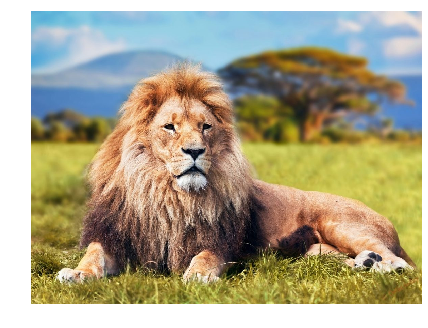

In [86]:
apply_model_to_image_raw_bytes(open("kartinka-dlya-detey-lev-1150x863.jpg", "rb").read())

a large group of people standing next to each other


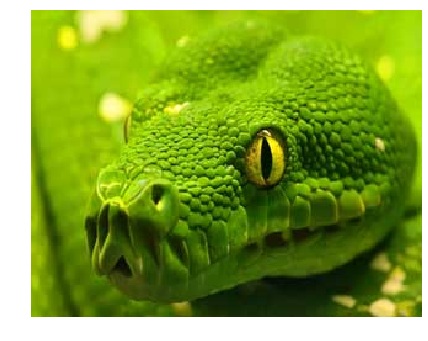

In [87]:
apply_model_to_image_raw_bytes(open("kartinki-pro-zmej.jpg", "rb").read())

a train is parked on the tracks near a bridge


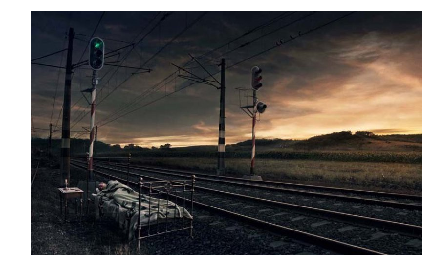

In [89]:
apply_model_to_image_raw_bytes(open("58e61c15039d3.jpg", "rb").read())

a bird is sitting on a perch in a tree


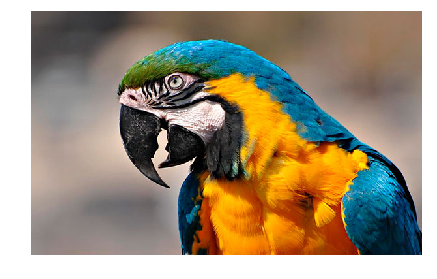

In [90]:
apply_model_to_image_raw_bytes(open("04.jpg", "rb").read())

a small dog is standing in the water


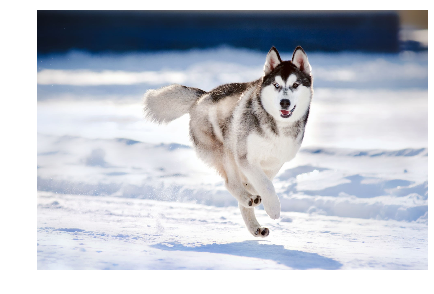

In [91]:
apply_model_to_image_raw_bytes(open("kartinka-simvol-2018-20.jpg", "rb").read())

That's it! 

Congratulations, you've trained your image captioning model and now can produce captions for any picture from the  Internet!